## Importing necessary libraries

In [2]:
# this will help in making the Python code more structured automatically (good coding practice)
#%load_ext nb_black

import warnings

warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Library to split data
from sklearn.model_selection import train_test_split

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 100)


# Libraries different ensemble classifiers
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    StackingClassifier,
)

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

# Libraries to get different metric scores
from sklearn import metrics
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

# To tune different models
from sklearn.model_selection import GridSearchCV

## Import Dataset

In [3]:
visa = pd.read_csv("EasyVisa.csv")

In [4]:
# copying data to another variable to avoid any changes to original data
data = visa.copy()

## Overview of the Dataset

#### View the first and last 5 rows of the dataset

In [5]:
data.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [6]:
data.tail()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
25475,EZYV25476,Asia,Bachelor's,Y,Y,2601,2008,South,77092.57,Year,Y,Certified
25476,EZYV25477,Asia,High School,Y,N,3274,2006,Northeast,279174.79,Year,Y,Certified
25477,EZYV25478,Asia,Master's,Y,N,1121,1910,South,146298.85,Year,N,Certified
25478,EZYV25479,Asia,Master's,Y,Y,1918,1887,West,86154.77,Year,Y,Certified
25479,EZYV25480,Asia,Bachelor's,Y,N,3195,1960,Midwest,70876.91,Year,Y,Certified


#### Understand the shape of the dataset

In [7]:
data.shape

(25480, 12)

* The dataset has 25480 rows and 12 columns 

#### Check the data types of the columns for the dataset

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB


* `no_of_employees`, ` yr_of_estab`, and `prevailing_wage` are numeric features while rest are objects.
* There are no null values in the dataset.

In [9]:
# checking for duplicate values
data.duplicated().sum()

0

- There are no duplicate values in the data. 

## Exploratory Data Analysis

#### Let's check the statistical summary of the data

In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_employees,25480.0,5667.043210,22877.928848,-26.0000,1022.00,2109.00,3504.0000,602069.00
yr_of_estab,25480.0,1979.409929,42.366929,1800.0000,1976.00,1997.00,2005.0000,2016.00
prevailing_wage,25480.0,74455.814592,52815.942327,2.1367,34015.48,70308.21,107735.5125,319210.27


**Observations:**
* The range of the number of employees in a company is huge. There are some anomalies in the data as we can see that the minimum number of employees is equal to -26, which is not possible. We will have to fix this.
* The year of establishment of companies ranges from 1800 to 2016, which seems fine.
* The average prevailing wage is 74455.81. There's also a very huge difference in 75th percentile and maximum value which indicates there might be outliers present in this column.

#### Fixing the negative values in number of employees columns

In [13]:
data.loc[data["no_of_employees"] < 0].shape

(33, 12)

* We will consider the 33 observations as data entry errors and take the absolute values for this column.

In [ ]:
# taking the absolute values for number of employees
data["no_of_employees"] = abs(data["no_of_employees"])

#### Let's check the count of each unique category in each of the categorical variables 

In [14]:
# Making a list of all catrgorical variables
cat_col = list(data.select_dtypes("object").columns)

# Printing number of count of each unique value in each column
for column in cat_col:
    print(data[column].value_counts())
    print("-" * 50)

EZYV01       1
EZYV16995    1
EZYV16993    1
EZYV16992    1
EZYV16991    1
            ..
EZYV8492     1
EZYV8491     1
EZYV8490     1
EZYV8489     1
EZYV25480    1
Name: case_id, Length: 25480, dtype: int64
--------------------------------------------------
Asia             16861
Europe            3732
North America     3292
South America      852
Africa             551
Oceania            192
Name: continent, dtype: int64
--------------------------------------------------
Bachelor's     10234
Master's        9634
High School     3420
Doctorate       2192
Name: education_of_employee, dtype: int64
--------------------------------------------------
Y    14802
N    10678
Name: has_job_experience, dtype: int64
--------------------------------------------------
N    22525
Y     2955
Name: requires_job_training, dtype: int64
--------------------------------------------------
Northeast    7195
South        7017
West         6586
Midwest      4307
Island        375
Name: region_of_employment, 

In [19]:
data.groupby(['continent']).count()

,case_id,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
continent,,,,,,,,,,,
Africa,551,551,551,551,551,551,551,551,551,551,551
Asia,16861,16861,16861,16861,16861,16861,16861,16861,16861,16861,16861
Europe,3732,3732,3732,3732,3732,3732,3732,3732,3732,3732,3732
North America,3292,3292,3292,3292,3292,3292,3292,3292,3292,3292,3292
Oceania,192,192,192,192,192,192,192,192,192,192,192
South America,852,852,852,852,852,852,852,852,852,852,852


**Observations:**
* Most of the applications in data are from Asians followed by Europeans.
* Most of the applicants have a bachelor's degree followed by a master's degree.
* Most of the applicants have job experience and do not require job training.
* Most applicants have their worksite in the Northeast region of the US.
* Most applicants will yearly unit of wage.
* Most of the visa applications are for full-time job positions.
* The target column case status is imbalanced with many applicants having a certified visa.

In [20]:
# checking the number of unique values
data["case_id"].nunique()

25480

* All the values in the case id column are unique.
* We can drop this column.

In [21]:
data.drop(["case_id"], axis=1, inplace=True)

### Univariate Analysis

In [22]:
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid = 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

#### Observations on number of employees

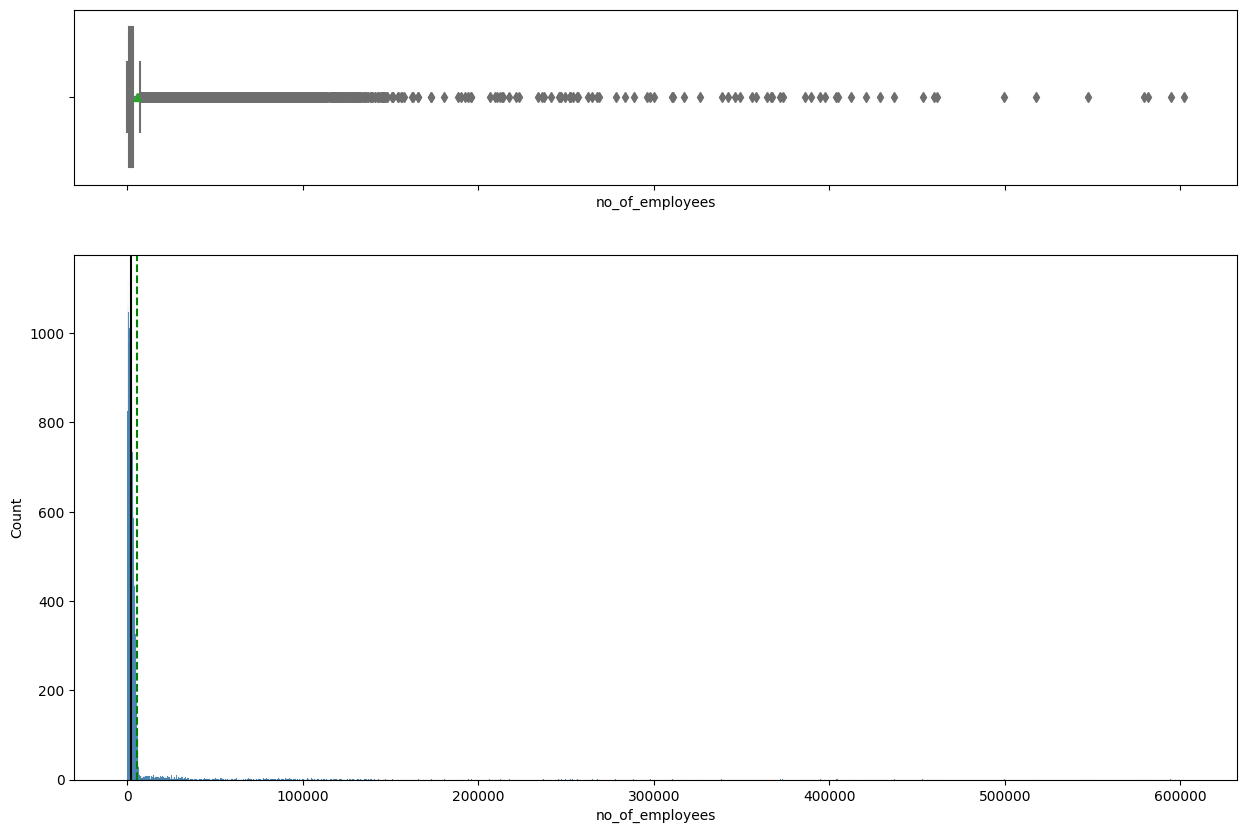

In [23]:
histogram_boxplot(data, "no_of_employees")

* The distribution of the number of employees is heavily right-skewed.
* Some companies have more than 500k employees. Such companies might have multiple offices around the world.

#### Observations on prevailing wage

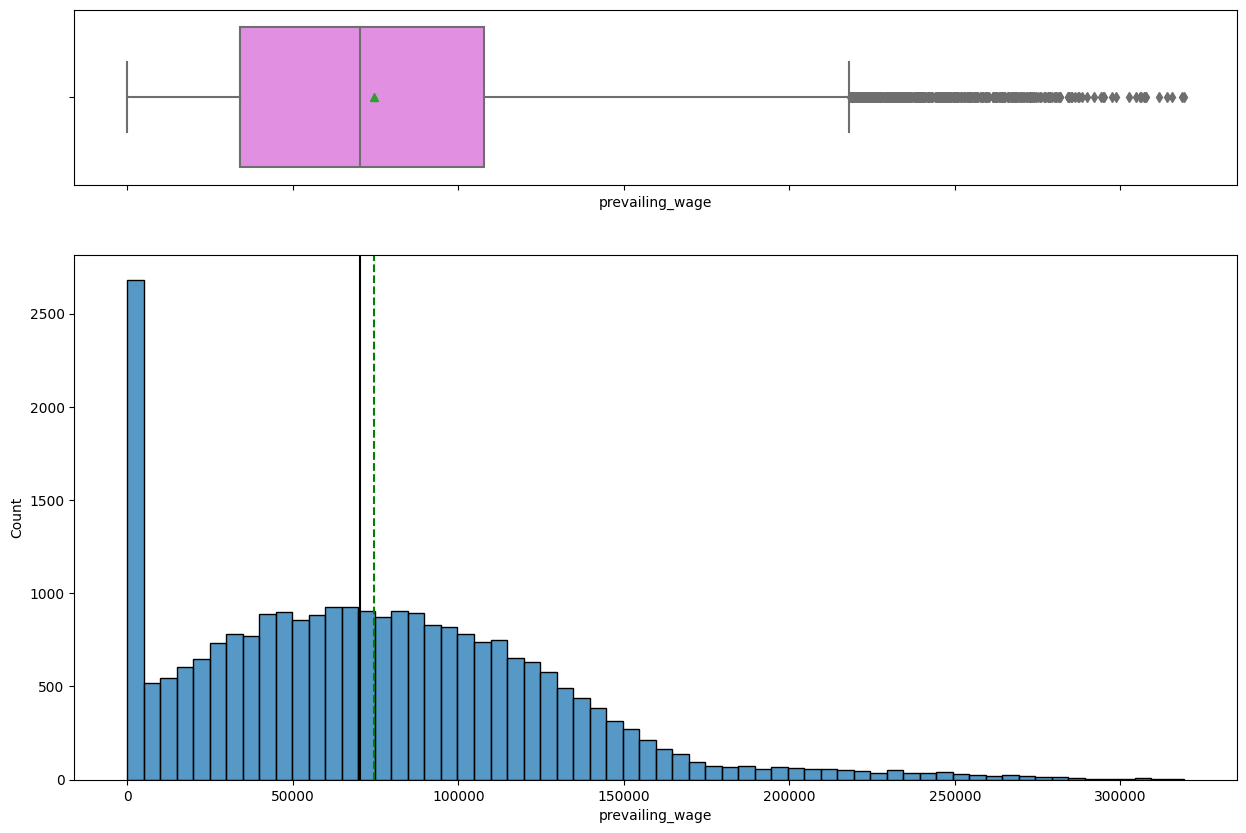

In [24]:
histogram_boxplot(data, "prevailing_wage")

* The distribution of prevailing wage is skewed to the right.
* There are some job roles where the prevailing wage is more than 200k.
* The distribution suggests that some applicants have prevailing wage around 0, let's have a look at them. As we say in the data summary the minimum value is 2.13.

In [25]:
# checking the observations which have less than 100 prevailing wage
data.loc[data["prevailing_wage"] < 100]

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
338,Asia,Bachelor's,Y,N,2114,2012,Northeast,15.7716,Hour,Y,Certified
634,Asia,Master's,N,N,834,1977,Northeast,3.3188,Hour,Y,Denied
839,Asia,High School,Y,N,4537,1999,West,61.1329,Hour,Y,Denied
876,South America,Bachelor's,Y,N,731,2004,Northeast,82.0029,Hour,Y,Denied
995,Asia,Master's,N,N,302,2000,South,47.4872,Hour,Y,Certified
...,...,...,...,...,...,...,...,...,...,...,...
25023,Asia,Bachelor's,N,Y,3200,1994,South,94.1546,Hour,Y,Denied
25258,Asia,Bachelor's,Y,N,3659,1997,South,79.1099,Hour,Y,Denied
25308,North America,Master's,N,N,82953,1977,Northeast,42.7705,Hour,Y,Denied
25329,Africa,Bachelor's,N,N,2172,1993,Northeast,32.9286,Hour,Y,Denied


* It looks like the unit of the wage for these observations is hours. 

In [26]:
data.loc[data["prevailing_wage"] < 100, "unit_of_wage"].value_counts()

Hour    176
Name: unit_of_wage, dtype: int64

* All such observations where the prevailing wage is less than 100 have the unit of wage as hours. This makes sense and confirms that these are not anomalous observations in the data.

In [54]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    

    for p in ax.patches:

        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        # get the coordinates of the label 
        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot
        

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

#### Observations on continent

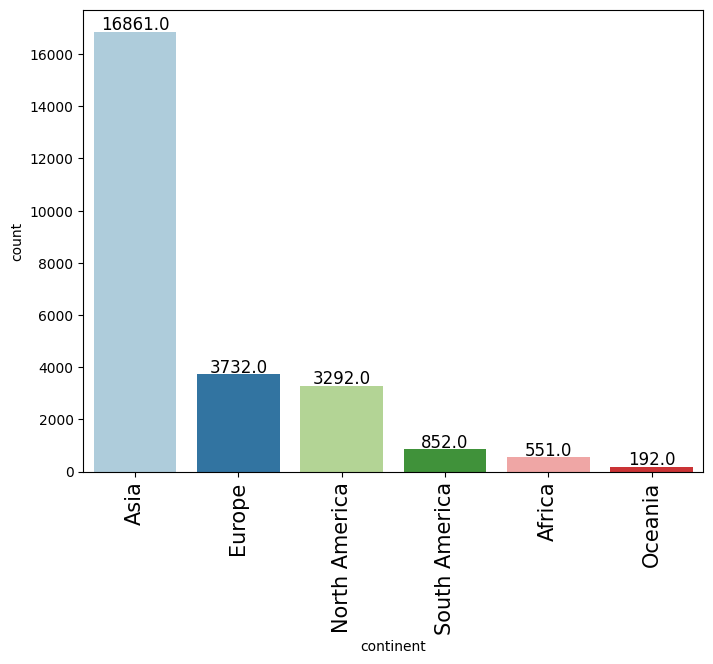

In [55]:
labeled_barplot(data, "continent", perc=False)

* More than half (66.2%) of the applicants are from Asia, followed by 14.6% of the applications from Europe.

#### Observations on education of employee

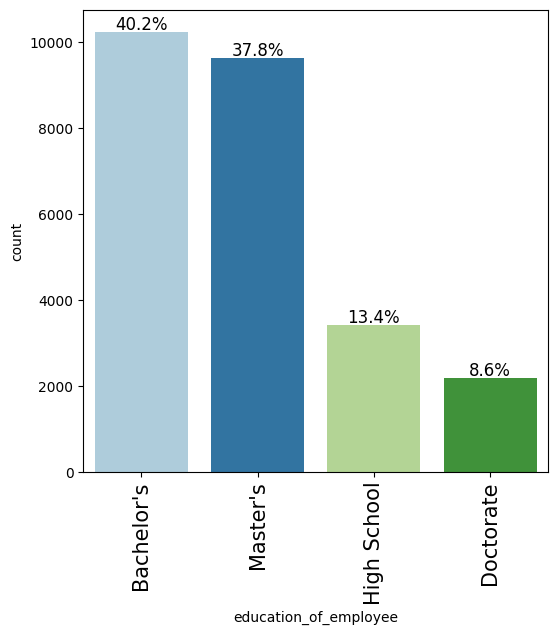

In [56]:
labeled_barplot(data, "education_of_employee", perc=True)

* 40.2% of the applicants have a bachelor's degree, followed by 37.8% having a master's degree.
* 8.6% of the applicants have a doctorate degree.

#### Observations on job experience

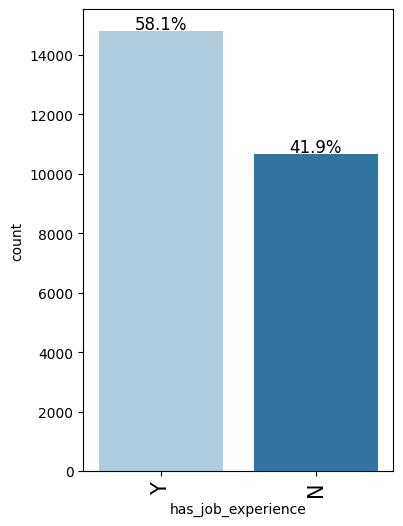

In [57]:
labeled_barplot(data, "has_job_experience", perc=True)

* 58.1% of the customers have job experience.

#### Observations on job training

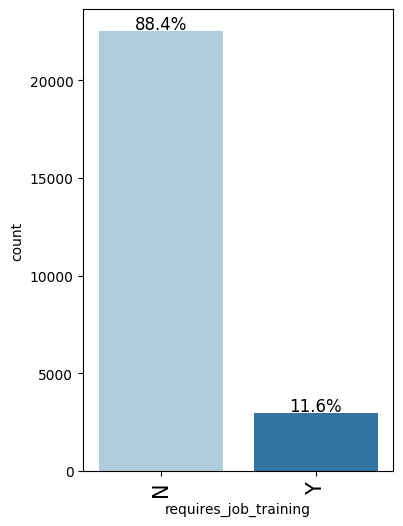

In [58]:
labeled_barplot(data, "requires_job_training", perc=True)

* 88.4% of the applicants do not require any job training.

#### Observations on region of employment

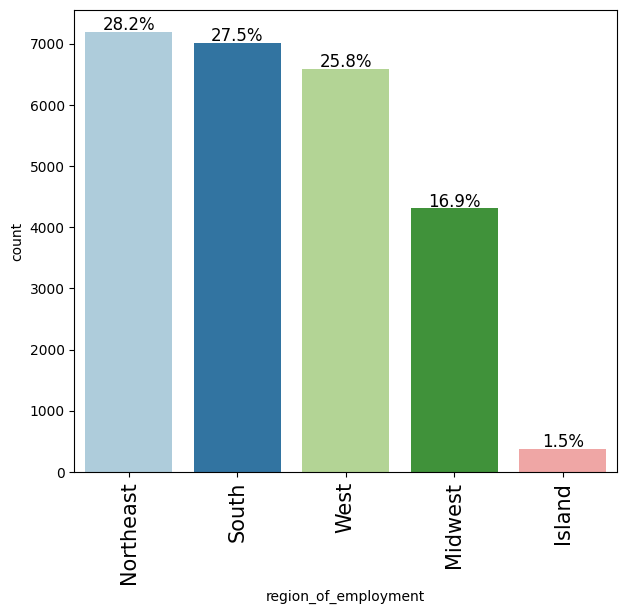

In [59]:
labeled_barplot(data, "region_of_employment", perc=True)

* Northeast, South, and West have almost equal percentages of applicants. (25%-28%)
* The Island regions have only 1.5% of the applicants.

#### Observations on unit of wage

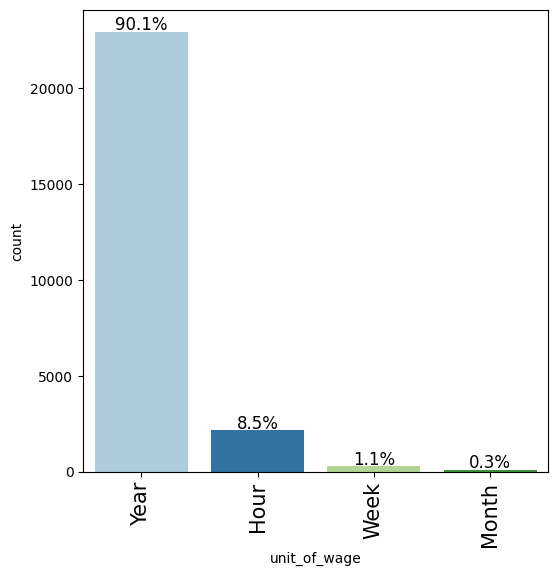

In [60]:
labeled_barplot(data, "unit_of_wage", perc=True)

* 90.1% of the applicants have a yearly unit of the wage, followed by 8.5% of the applicants having hourly wages.

#### Observations on case status

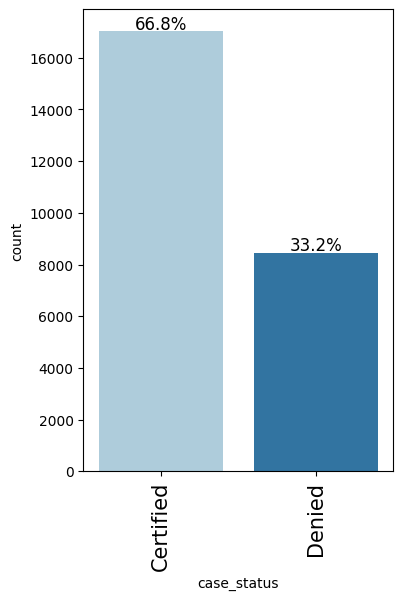

In [61]:
labeled_barplot(data, "case_status", perc=True)

* 66.8% of the visas were certified.

### Bivariate Analysis

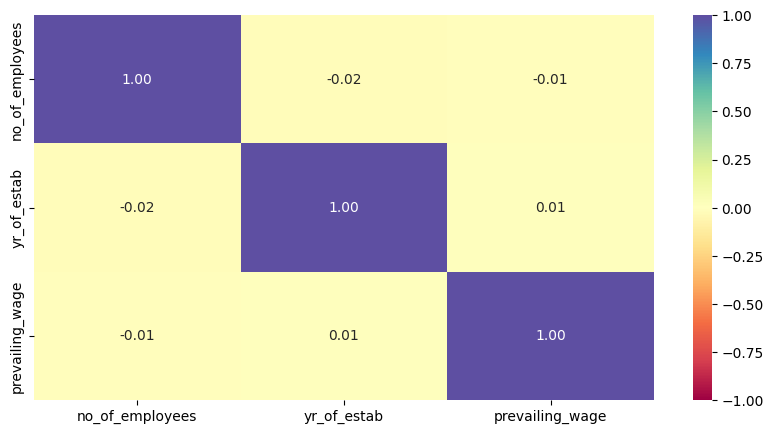

In [62]:
cols_list = data.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(10, 5))
sns.heatmap(
    data[cols_list].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

* There's no correlation within the independent features of the data.

**Creating functions that will help us with further analysis.**

In [63]:
### function to plot distributions wrt target


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

In [87]:
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[0]
 
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    ax = tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))

    # label = "{:.1f}%".format(
    #             100 * ax.get_height() / count
    #         )
    for p in ax.patches:
        
        label = "{:.1f}%".format(
                100 * p.get_height()
            )
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate(
            label,
            (x,y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )
        break

    print('label',label)
    # plt.annotate(
    #     label,
        
    # )
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

#### Those with higher education may want to travel abroad for a well-paid job. Let's find out if education has any impact on visa certification

case_status            Certified  Denied    All
education_of_employee                          
All                        17018    8462  25480
Master's                    7575    2059   9634
Bachelor's                  6367    3867  10234
Doctorate                   1912     280   2192
High School                 1164    2256   3420
------------------------------------------------------------------------------------------------------------------------
Rectangle(xy=(-0.25, 0), width=0.5, height=0.872263, angle=0)
label 21.8%


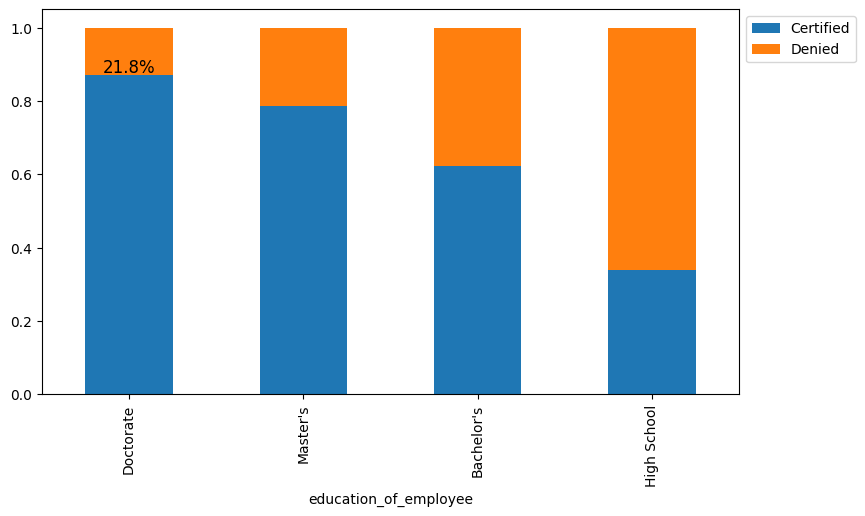

In [88]:
stacked_barplot(data, "education_of_employee", "case_status")

* Education seems to have a positive relationship with the certification of visa that is higher the education higher are the chances of visa getting certified.
* Around 85% of the visa applications got certified for the applicants with Doctorate degree. While 80% of the visa applications got certified for the applicants with Master's degree.
* Around 60% of the visa applications got certified for applicants with Bachelor's degrees.
* Applicants who do not have a degree and have graduated from high school are more likely to have their applications denied.

#### Different regions have different requirements of talent having diverse educational backgrounds. Let's analyze it further

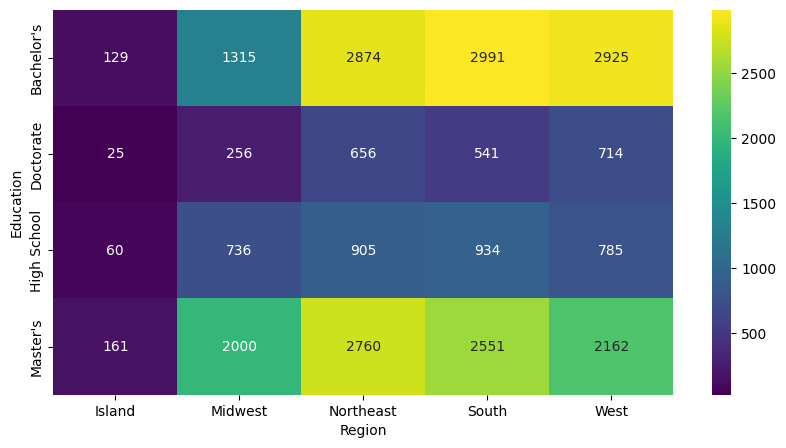

In [70]:
plt.figure(figsize=(10, 5))
sns.heatmap(
    pd.crosstab(data["education_of_employee"], data["region_of_employment"]),
    annot=True,
    fmt="g",
    cmap="viridis",
)
plt.ylabel("Education")
plt.xlabel("Region")
plt.show()

* The requirement for the applicants who have passed high school is most in the South region, followed by Northeast region.
* The requirement for Bachelor's is mostly in South region, followed by West region.
* The requirement for Master's is most in Northeast region, followed by South region.
* The requirement for Doctorate's is mostly in West region, followed by Northeast region.

#### Let's have a look at the percentage of visa certifications across each region

case_status           Certified  Denied    All
region_of_employment                          
All                       17018    8462  25480
Northeast                  4526    2669   7195
West                       4100    2486   6586
South                      4913    2104   7017
Midwest                    3253    1054   4307
Island                      226     149    375
------------------------------------------------------------------------------------------------------------------------


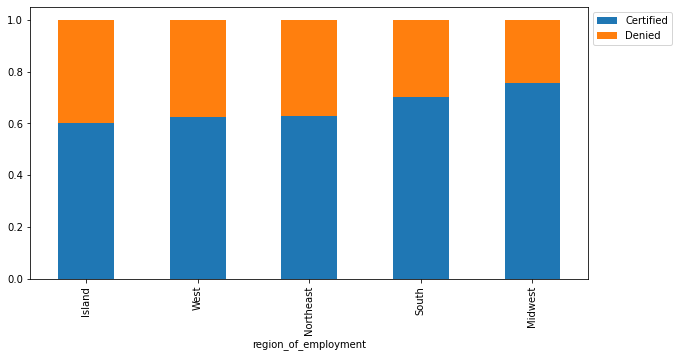

In [ ]:
stacked_barplot(data, "region_of_employment", "case_status")

* Midwest region sees the highest number of visa certifications - around 75%, followed by the south region that sees around 70% of the visa applications getting certified.
* Island, West, and Northeast region has an almost equal percentage of visa certifications.

#### Lets' similarly check for the continents and find out how the visa status vary across different continents.

case_status    Certified  Denied    All
continent                              
All                17018    8462  25480
Asia               11012    5849  16861
North America       2037    1255   3292
Europe              2957     775   3732
South America        493     359    852
Africa               397     154    551
Oceania              122      70    192
------------------------------------------------------------------------------------------------------------------------


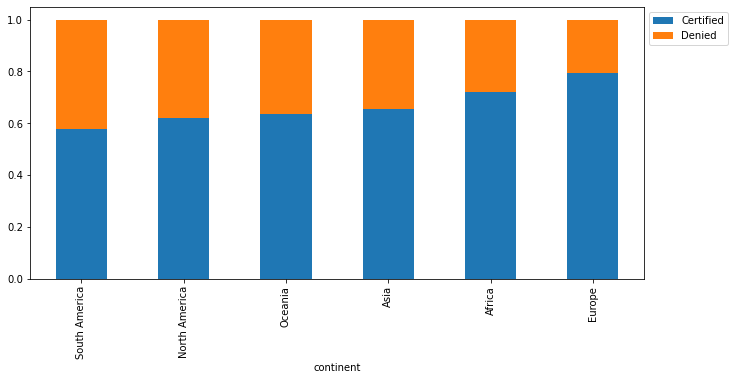

In [ ]:
stacked_barplot(data, "continent", "case_status")

* Applications from Europe and Africa have a higher chance of getting certified.
* Around 80% of the applications from Europe are certified.
* Asia has the third-highest percentage (Around 60%) of visa certification and has the highest number of applications.

#### Experienced professionals might look abroad for opportunities to improve their lifestyles and career development. Let's see if having work experience has any influence over visa certification

case_status         Certified  Denied    All
has_job_experience                          
All                     17018    8462  25480
N                        5994    4684  10678
Y                       11024    3778  14802
------------------------------------------------------------------------------------------------------------------------


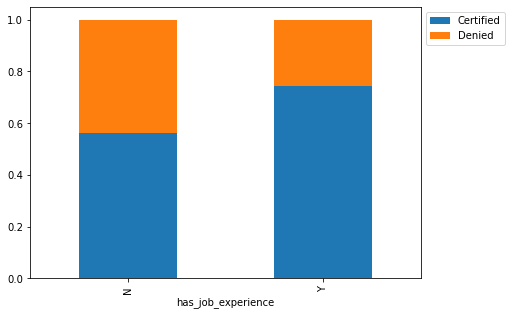

In [ ]:
stacked_barplot(data, "has_job_experience", "case_status")

* Having job experience seems to be a key differentiator between visa applications getting certified or denied.
* Around 80% of the applications were certified for the applicants who have some job experience as compared to the applicants who do not have any job experience. 
* Applicants without job experiences saw only 60% of the visa applications getting certified.

#### Do the employees who have prior work experience require any job training?

requires_job_training      N     Y    All
has_job_experience                       
All                    22525  2955  25480
N                       8988  1690  10678
Y                      13537  1265  14802
------------------------------------------------------------------------------------------------------------------------


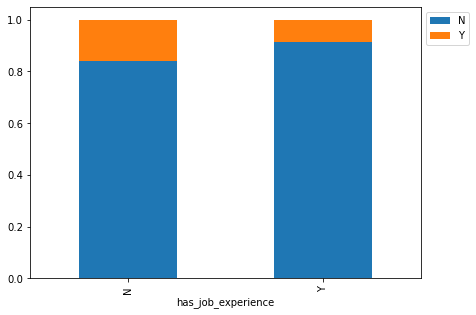

In [ ]:
stacked_barplot(data, "has_job_experience", "requires_job_training")

* Less percentage of applicants require job training if they have prior work experience.

#### The US government has established a prevailing wage to protect local talent and foreign workers. Let's analyze the data and see if the visa status changes with the prevailing wage

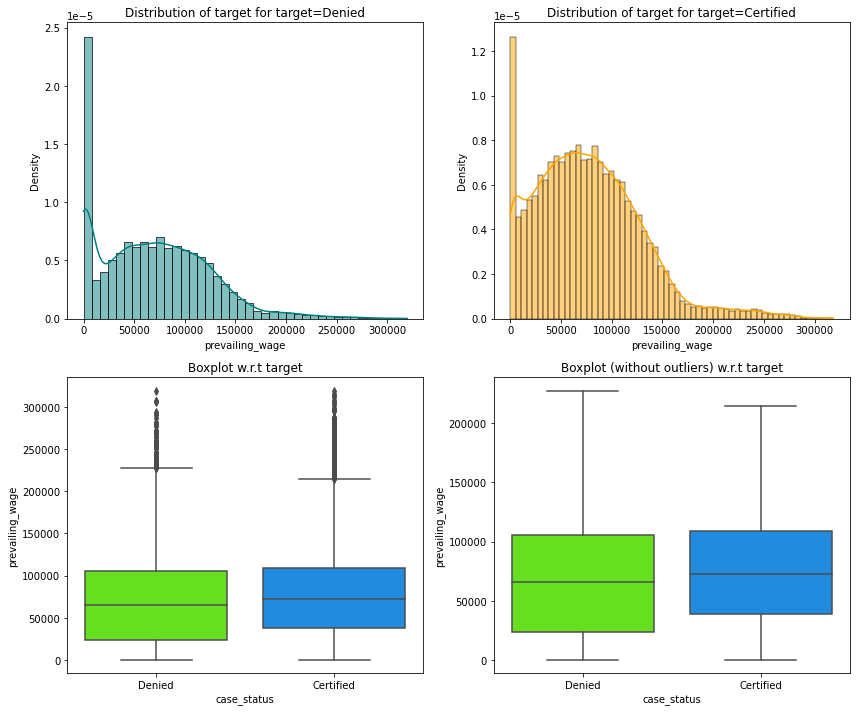

In [ ]:
distribution_plot_wrt_target(data, "prevailing_wage", "case_status")

* The median prevailing wage for the certified applications is slightly higher as compared to denied applications.

#### Checking if the prevailing wage is similar across all the regions of the US

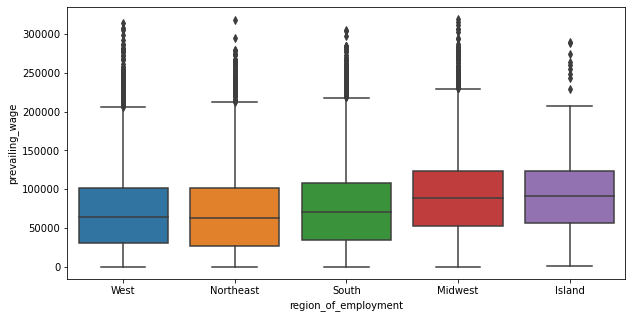

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x="region_of_employment", y="prevailing_wage")
plt.show()

* Midwest and Island regions have slightly higher prevailing wages as compared to other regions. 
* The distribution of prevailing wage is similar across West, Northeast, and South regions.

#### The prevailing wage has different units (Hourly, Weekly, etc). Let's find out if it has any impact on visa applications getting certified.

case_status   Certified  Denied    All
unit_of_wage                          
All               17018    8462  25480
Year              16047    6915  22962
Hour                747    1410   2157
Week                169     103    272
Month                55      34     89
------------------------------------------------------------------------------------------------------------------------


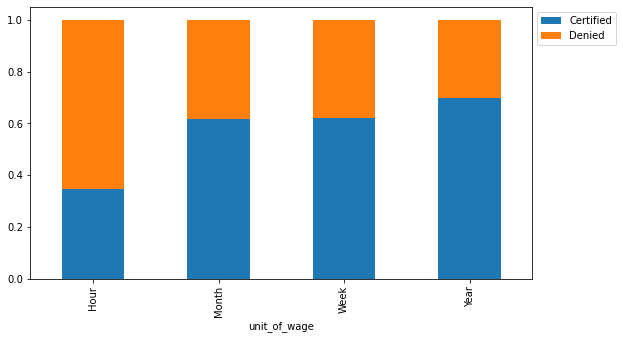

In [ ]:
stacked_barplot(data, "unit_of_wage", "case_status")

* Unit of prevailing wage is an important factor for differentiating between a certified and a denied visa application.
* If the unit of prevailing wage is Yearly, there's a high chance of the application getting certified.
* Around 75% of the applications were certified for the applicants who have a yearly unit of wage. While only 35% of the applications were certified for applicants who have an hourly unit of wage.
* Monthly and Weekly units of prevailing wage have the same percentage of visa applications getting certified.

## Data Pre-processing

### Outlier Check

- Let's check for outliers in the data.

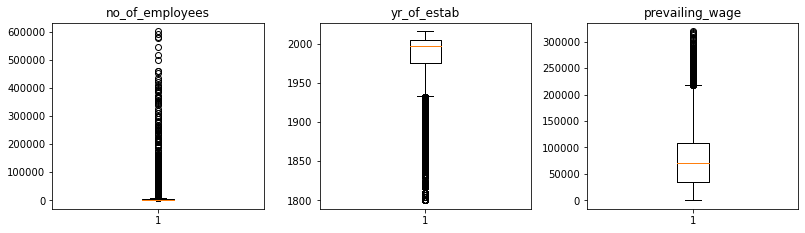

In [ ]:
# outlier detection using boxplot
numeric_columns = data.select_dtypes(include=np.number).columns.tolist()


plt.figure(figsize=(15, 12))

for i, variable in enumerate(numeric_columns):
    plt.subplot(4, 4, i + 1)
    plt.boxplot(data[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

**Observations**

- There are quite a few outliers in the data.
- However, we will not treat them as they are proper values.

### Data Preparation for modeling

- We want to predict which visa will be certified.
- Before we proceed to build a model, we'll have to encode categorical features.
- We'll split the data into train and test to be able to evaluate the model that we build on the train data.

In [ ]:
data["case_status"] = data["case_status"].apply(lambda x: 1 if x == "Certified" else 0)

X = data.drop(["case_status"], axis=1)
Y = data["case_status"]


X = pd.get_dummies(X, drop_first=True)

# Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.30, random_state=1, stratify=Y
)

In [ ]:
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (17836, 21)
Shape of test set :  (7644, 21)
Percentage of classes in training set:
1    0.667919
0    0.332081
Name: case_status, dtype: float64
Percentage of classes in test set:
1    0.667844
0    0.332156
Name: case_status, dtype: float64


## Model evaluation criterion

**Model can make wrong predictions as**:

1. Model predicts that the visa application will get certified but in reality, the visa application should get denied.
2. Model predicts that the visa application will not get certified but in reality, the visa application should get certified. 

**Which case is more important?** 
* Both the cases are important as:

* If a visa is certified when it had to be denied a wrong employee will get the job position while US citizens will miss the opportunity to work on that position.

* If a visa is denied when it had to be certified the U.S. will lose a suitable human resource that can contribute to the economy. 


**How to reduce the losses?**

* `F1 Score` can be used a the metric for evaluation of the model, greater the F1  score higher are the chances of minimizing False Negatives and False Positives. 
* We will use balanced class weights so that model focuses equally on both classes.

First, let's create functions to calculate different metrics and confusion matrix so that we don't have to use the same code repeatedly for each model.
* The model_performance_classification_sklearn function will be used to check the model performance of models. 
* The confusion_matrix_sklearn function will be used to plot the confusion matrix.

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn


def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [ ]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

## Decision Tree - Model Building and Hyperparameter Tuning

In [ ]:
model = DecisionTreeClassifier(random_state=1)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

#### Checking model performance on training set

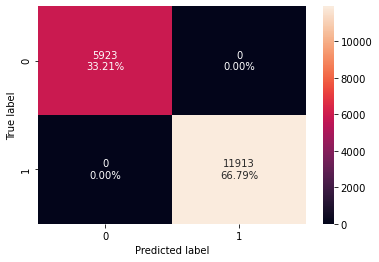

In [ ]:
confusion_matrix_sklearn(model, X_train, y_train)

In [ ]:
decision_tree_perf_train = model_performance_classification_sklearn(
    model, X_train, y_train
)
decision_tree_perf_train

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


* 0 errors on the training set, each sample has been classified correctly.
* Model has performed very well on the training set.
* As we know, a decision tree will continue to grow and classify each data point correctly if no restrictions are applied as the trees will learn all the patterns in the training set.
* Let's check the performance on test data to see if the model is overfitting.

#### Checking model performance on test set

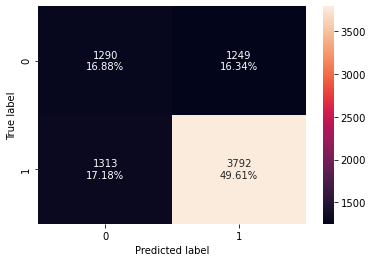

In [ ]:
confusion_matrix_sklearn(model, X_test, y_test)

In [ ]:
decision_tree_perf_test = model_performance_classification_sklearn(
    model, X_test, y_test
)
decision_tree_perf_test

,Accuracy,Recall,Precision,F1
0,0.664835,0.742801,0.752232,0.747487


* The decision tree model is overfitting the data as expected and not able to generalize well on the test set.
* We will have to prune the decision tree.

### Hyperparameter Tuning - Decision Tree

In [ ]:
# Choose the type of classifier.
dtree_estimator = DecisionTreeClassifier(class_weight="balanced", random_state=1)

# Grid of parameters to choose from
parameters = {
    "max_depth": np.arange(10, 30, 5),
    "min_samples_leaf": [3, 5, 7],
    "max_leaf_nodes": [2, 3, 5],
    "min_impurity_decrease": [0.0001, 0.001],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(dtree_estimator, parameters, scoring=scorer, n_jobs=-1)

grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
dtree_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data.
dtree_estimator.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10, max_leaf_nodes=2,
                       min_impurity_decrease=0.0001, min_samples_leaf=3,
                       random_state=1)

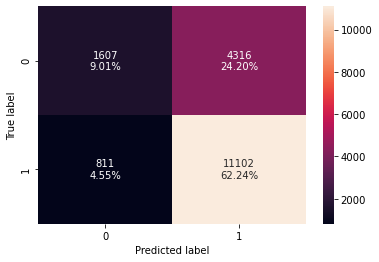

In [ ]:
confusion_matrix_sklearn(dtree_estimator, X_train, y_train)

In [ ]:
dtree_estimator_model_train_perf = model_performance_classification_sklearn(
    dtree_estimator, X_train, y_train
)
dtree_estimator_model_train_perf

,Accuracy,Recall,Precision,F1
0,0.712548,0.931923,0.720067,0.812411


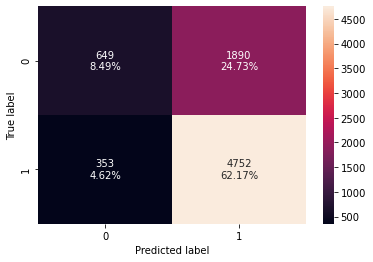

In [ ]:
confusion_matrix_sklearn(dtree_estimator, X_test, y_test)

In [ ]:
dtree_estimator_model_test_perf = model_performance_classification_sklearn(
    dtree_estimator, X_test, y_test
)
dtree_estimator_model_test_perf

,Accuracy,Recall,Precision,F1
0,0.706567,0.930852,0.715447,0.809058


* The decision tree model has a very high recall but, the precision is quite less.
* The performance of the model after hyperparameter tuning has become generalized.
* We are getting an F1 score of 0.81 and 0.80 on the training and test set, respectively.
* Let's try building some ensemble models and see if the metrics improve.

## Bagging - Model Building and Hyperparameter Tuning

### Bagging Classifier

In [ ]:
bagging_classifier = BaggingClassifier(random_state=1)
bagging_classifier.fit(X_train, y_train)

BaggingClassifier(random_state=1)

#### Checking model performance on training set

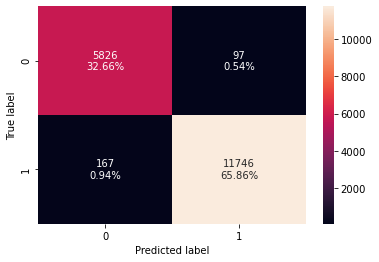

In [ ]:
confusion_matrix_sklearn(bagging_classifier, X_train, y_train)

In [ ]:
bagging_classifier_model_train_perf = model_performance_classification_sklearn(
    bagging_classifier, X_train, y_train
)
bagging_classifier_model_train_perf

,Accuracy,Recall,Precision,F1
0,0.985198,0.985982,0.99181,0.988887


#### Checking model performance on test set

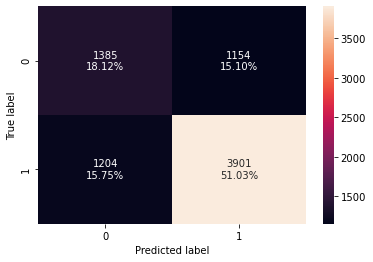

In [ ]:
confusion_matrix_sklearn(bagging_classifier, X_test, y_test)

In [ ]:
bagging_classifier_model_test_perf = model_performance_classification_sklearn(
    bagging_classifier, X_test, y_test
)
bagging_classifier_model_test_perf

,Accuracy,Recall,Precision,F1
0,0.691523,0.764153,0.771711,0.767913


* The bagging classifier is overfitting on the training set like the decision tree model.
* We'll try to reduce overfitting and improve the performance by hyperparameter tuning.

### Hyperparameter Tuning - Bagging Classifier

In [ ]:
# Choose the type of classifier.
bagging_estimator_tuned = BaggingClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {
    "max_samples": [0.7, 0.8, 0.9],
    "max_features": [0.7, 0.8, 0.9],
    "n_estimators": np.arange(90, 120, 10),
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(bagging_estimator_tuned, parameters, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
bagging_estimator_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
bagging_estimator_tuned.fit(X_train, y_train)

BaggingClassifier(max_features=0.7, max_samples=0.7, n_estimators=100,
                  random_state=1)

#### Checking model performance on training set

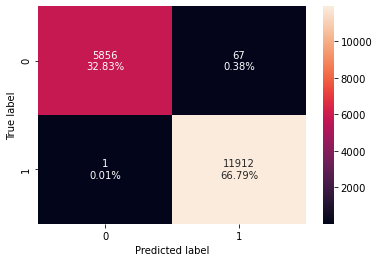

In [ ]:
confusion_matrix_sklearn(bagging_estimator_tuned, X_train, y_train)

In [ ]:
bagging_estimator_tuned_model_train_perf = model_performance_classification_sklearn(
    bagging_estimator_tuned, X_train, y_train
)
bagging_estimator_tuned_model_train_perf

,Accuracy,Recall,Precision,F1
0,0.996187,0.999916,0.994407,0.997154


#### Checking model performance on test set

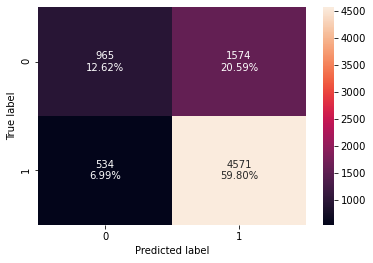

In [ ]:
confusion_matrix_sklearn(bagging_estimator_tuned, X_test, y_test)

In [ ]:
bagging_estimator_tuned_model_test_perf = model_performance_classification_sklearn(
    bagging_estimator_tuned, X_test, y_test
)
bagging_estimator_tuned_model_test_perf

,Accuracy,Recall,Precision,F1
0,0.724228,0.895397,0.743857,0.812622


* After tuning the hyperparameters the bagging classifier is still overfitting.
* There's a big difference in the training and the test recall.

### Random Forest

In [ ]:
# Fitting the model
rf_estimator = RandomForestClassifier(random_state=1, class_weight="balanced")
rf_estimator.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=1)

#### Checking model performance on training set

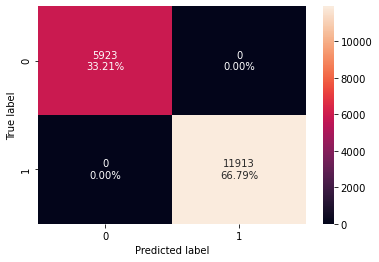

In [ ]:
confusion_matrix_sklearn(rf_estimator, X_train, y_train)

In [ ]:
# Calculating different metrics
rf_estimator_model_train_perf = model_performance_classification_sklearn(
    rf_estimator, X_train, y_train
)
rf_estimator_model_train_perf

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


#### Checking model performance on test set

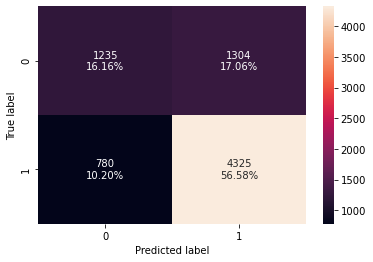

In [ ]:
confusion_matrix_sklearn(rf_estimator, X_test, y_test)

In [ ]:
rf_estimator_model_test_perf = model_performance_classification_sklearn(
    rf_estimator, X_test, y_test
)
rf_estimator_model_test_perf

,Accuracy,Recall,Precision,F1
0,0.727368,0.847209,0.768343,0.805851


- With default parameters, random forest is overfitting the training data.
- We'll try to reduce overfitting and improve recall by hyperparameter tuning.

### Hyperparameter Tuning - Random Forest

In [ ]:
# Choose the type of classifier.
rf_tuned = RandomForestClassifier(random_state=1, oob_score=True, bootstrap=True)

parameters = {
    "max_depth": list(np.arange(5, 15, 5)),
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [3, 5, 7],
    "n_estimators": np.arange(10, 40, 10),
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=acc_scorer, cv=5, n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_split=7,
                       n_estimators=20, oob_score=True, random_state=1)

#### Checking model performance on training set

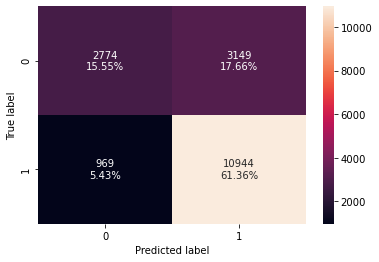

In [ ]:
confusion_matrix_sklearn(rf_tuned, X_train, y_train)

In [ ]:
rf_tuned_model_train_perf = model_performance_classification_sklearn(
    rf_tuned, X_train, y_train
)
rf_tuned_model_train_perf

,Accuracy,Recall,Precision,F1
0,0.769119,0.91866,0.776556,0.841652


#### Checking model performance on test set

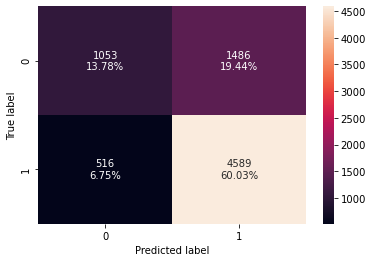

In [ ]:
confusion_matrix_sklearn(rf_tuned, X_test, y_test)

In [ ]:
rf_tuned_model_test_perf = model_performance_classification_sklearn(
    rf_tuned, X_test, y_test
)
rf_tuned_model_test_perf

,Accuracy,Recall,Precision,F1
0,0.738095,0.898923,0.755391,0.82093


* After hyperparameter tuning the model performance has generalized.
* We have an F1 score of 0.84 and 0.82 on the training and test data, respectively.
* The model has a high recall and a good precision.

## Boosting - Model Building and Hyperparameter Tuning

### AdaBoost Classifier

In [ ]:
ab_classifier = AdaBoostClassifier(random_state=1)
ab_classifier.fit(X_train, y_train)

AdaBoostClassifier(random_state=1)

#### Checking model performance on training set

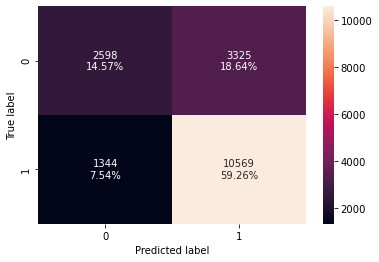

In [ ]:
confusion_matrix_sklearn(ab_classifier, X_train, y_train)

In [ ]:
ab_classifier_model_train_perf = model_performance_classification_sklearn(
    ab_classifier, X_train, y_train
)
ab_classifier_model_train_perf

,Accuracy,Recall,Precision,F1
0,0.738226,0.887182,0.760688,0.81908


#### Checking model performance on test set

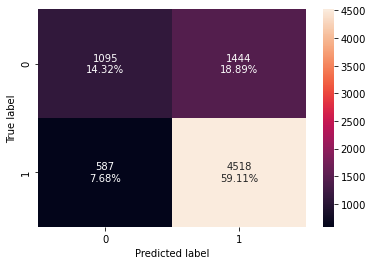

In [ ]:
confusion_matrix_sklearn(ab_classifier, X_test, y_test)

In [ ]:
ab_classifier_model_test_perf = model_performance_classification_sklearn(
    ab_classifier, X_test, y_test
)
ab_classifier_model_test_perf

,Accuracy,Recall,Precision,F1
0,0.734301,0.885015,0.757799,0.816481


* The model is giving a generalized performance.
* We have received a good F1 score of 0.81 on both the training and test set.

### Hyperparameter Tuning - AdaBoost Classifier

In [ ]:
# Choose the type of classifier.
abc_tuned = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {
    # Let's try different max_depth for base_estimator
    "base_estimator": [
        DecisionTreeClassifier(max_depth=1, class_weight="balanced", random_state=1),
        DecisionTreeClassifier(max_depth=2, class_weight="balanced", random_state=1),
        DecisionTreeClassifier(max_depth=3, class_weight="balanced", random_state=1),
    ],
    "n_estimators": np.arange(60, 100, 10),
    "learning_rate": np.arange(0.1, 0.4, 0.1),
}

# Type of scoring used to compare parameter  combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(abc_tuned, parameters, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
abc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=1,
                                                         random_state=1),
                   learning_rate=0.1, n_estimators=90, random_state=1)

#### Checking model performance on training set

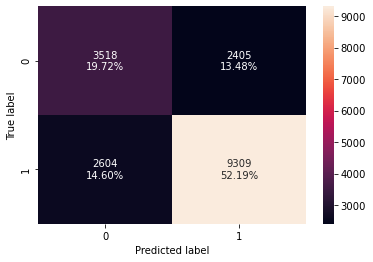

In [ ]:
confusion_matrix_sklearn(abc_tuned, X_train, y_train)

In [ ]:
abc_tuned_model_train_perf = model_performance_classification_sklearn(
    abc_tuned, X_train, y_train
)
abc_tuned_model_train_perf

,Accuracy,Recall,Precision,F1
0,0.719163,0.781415,0.79469,0.787997


#### Checking model performance on test set

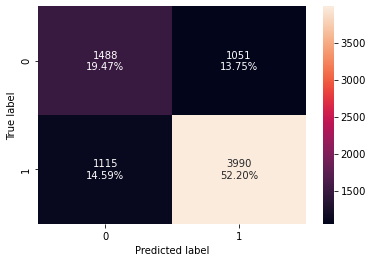

In [ ]:
confusion_matrix_sklearn(abc_tuned, X_test, y_test)

In [ ]:
abc_tuned_model_test_perf = model_performance_classification_sklearn(
    abc_tuned, X_test, y_test
)
abc_tuned_model_test_perf

,Accuracy,Recall,Precision,F1
0,0.716641,0.781587,0.79151,0.786517


* After tuning the F1 score has reduced.
* The recall of the model has reduced but the precision has improved.

### Gradient Boosting Classifier

In [ ]:
gb_classifier = GradientBoostingClassifier(random_state=1)
gb_classifier.fit(X_train, y_train)

GradientBoostingClassifier(random_state=1)

#### Checking model performance on training set

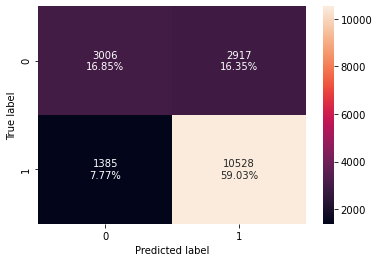

In [ ]:
confusion_matrix_sklearn(gb_classifier, X_train, y_train)

In [ ]:
gb_classifier_model_train_perf = model_performance_classification_sklearn(
    gb_classifier, X_train, y_train
)
gb_classifier_model_train_perf

,Accuracy,Recall,Precision,F1
0,0.758802,0.88374,0.783042,0.830349


#### Checking model performance on test set

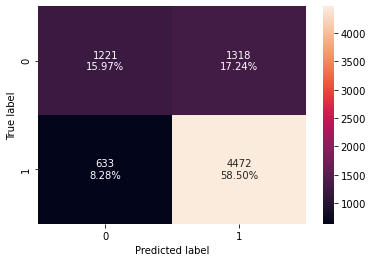

In [ ]:
confusion_matrix_sklearn(gb_classifier, X_test, y_test)

In [ ]:
gb_classifier_model_test_perf = model_performance_classification_sklearn(
    gb_classifier, X_test, y_test
)
gb_classifier_model_test_perf

,Accuracy,Recall,Precision,F1
0,0.744767,0.876004,0.772366,0.820927


* The model is giving a good and generalized performance.
* We are getting the F1 score of 0.83 and 0.82 on the training and test set, respectively.
* Let's see if the performance can be improved further by hyperparameter tuning.

### Hyperparameter Tuning - Gradient Boosting Classifier

In [ ]:
# Choose the type of classifier.
gbc_tuned = GradientBoostingClassifier(
    init=AdaBoostClassifier(random_state=1), random_state=1
)

# Grid of parameters to choose from
parameters = {
    "n_estimators": [200, 250, 300],
    "subsample": [0.8, 0.9, 1],
    "max_features": [0.7, 0.8, 0.9, 1],
    "learning_rate": np.arange(0.1, 0.4, 0.1),
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(gbc_tuned, parameters, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_tuned.fit(X_train, y_train)

GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                           max_features=0.8, n_estimators=200, random_state=1,
                           subsample=1)

#### Checking model performance on training set

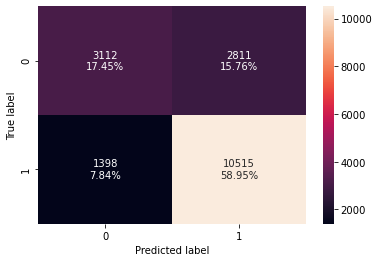

In [ ]:
confusion_matrix_sklearn(gbc_tuned, X_train, y_train)

In [ ]:
gbc_tuned_model_train_perf = model_performance_classification_sklearn(
    gbc_tuned, X_train, y_train
)
gbc_tuned_model_train_perf

,Accuracy,Recall,Precision,F1
0,0.764017,0.882649,0.789059,0.833234


#### Checking model performance on test set

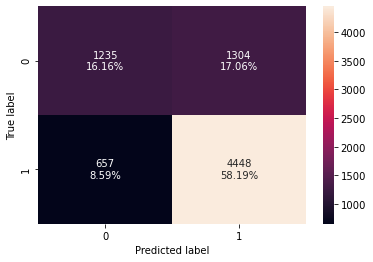

In [ ]:
confusion_matrix_sklearn(gbc_tuned, X_test, y_test)

In [ ]:
gbc_tuned_model_test_perf = model_performance_classification_sklearn(
    gbc_tuned, X_test, y_test
)
gbc_tuned_model_test_perf

,Accuracy,Recall,Precision,F1
0,0.743459,0.871303,0.773296,0.819379


* After tuning there is not much change in the model performance as compared to the model with default values of hyperparameters.

### XGBoost Classifier

In [ ]:
xgb_classifier = XGBClassifier(random_state=1, eval_metric="logloss")
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=1, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

#### Checking model performance on training set

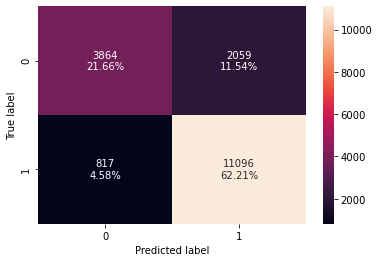

In [ ]:
confusion_matrix_sklearn(xgb_classifier, X_train, y_train)

In [ ]:
xgb_classifier_model_train_perf = model_performance_classification_sklearn(
    xgb_classifier, X_train, y_train
)
xgb_classifier_model_train_perf

,Accuracy,Recall,Precision,F1
0,0.838753,0.931419,0.843482,0.885272


#### Checking model performance on test set

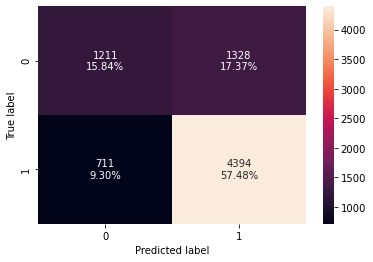

In [ ]:
confusion_matrix_sklearn(xgb_classifier, X_test, y_test)

In [ ]:
xgb_classifier_model_test_perf = model_performance_classification_sklearn(
    xgb_classifier, X_test, y_test
)
xgb_classifier_model_test_perf

,Accuracy,Recall,Precision,F1
0,0.733255,0.860725,0.767913,0.811675


* The XGBoost model on the training set has performed very well but it is not able to generalize on the test set.
* Let's try and tune the hyperparameters and see if the performance can be generalized.

### Hyperparameter Tuning - XGBoost Classifier

In [ ]:
# Choose the type of classifier.
xgb_tuned = XGBClassifier(random_state=1, eval_metric="logloss")

# Grid of parameters to choose from
parameters = {
    "n_estimators": np.arange(150, 250, 50),
    "scale_pos_weight": [1, 2],
    "subsample": [0.9, 1],
    "learning_rate": np.arange(0.1, 0.21, 0.1),
    "gamma": [3, 5],
    "colsample_bytree": [0.8, 0.9],
    "colsample_bylevel": [ 0.9, 1],
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, eval_metric='logloss',
              gamma=5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=8,
              num_parallel_tree=1, random_state=1, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

#### Checking model performance on training set

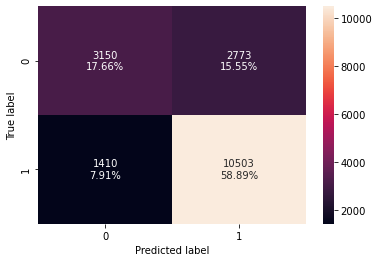

In [ ]:
confusion_matrix_sklearn(xgb_tuned, X_train, y_train)

In [ ]:
xgb_tuned_model_train_perf = model_performance_classification_sklearn(
    xgb_tuned, X_train, y_train
)
xgb_tuned_model_train_perf

,Accuracy,Recall,Precision,F1
0,0.765474,0.881642,0.791127,0.833935


#### Checking model performance on test set

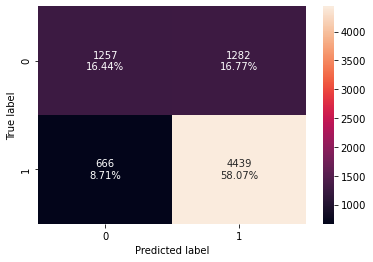

In [ ]:
confusion_matrix_sklearn(xgb_tuned, X_test, y_test)

In [ ]:
xgb_tuned_model_test_perf = model_performance_classification_sklearn(
    xgb_tuned, X_test, y_test
)
xgb_tuned_model_test_perf

,Accuracy,Recall,Precision,F1
0,0.74516,0.86954,0.775913,0.820063


* XGBoost model after tuning is giving a good and generalized performance.
* We have received the F1 score of 0.83 and 0.82 on the training and the test set, respectively.

## Stacking Classifier

In [ ]:
estimators = [
    ("AdaBoost", ab_classifier),
    ("Gradient Boosting", gbc_tuned),
    ("Random Forest", rf_tuned),
]

final_estimator = xgb_tuned

stacking_classifier = StackingClassifier(
    estimators=estimators, final_estimator=final_estimator
)

stacking_classifier.fit(X_train, y_train)

StackingClassifier(estimators=[('AdaBoost', AdaBoostClassifier(random_state=1)),
                               ('Gradient Boosting',
                                GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                                                           max_features=0.8,
                                                           n_estimators=200,
                                                           random_state=1,
                                                           subsample=1)),
                               ('Random Forest',
                                RandomForestClassifier(max_depth=10,
                                                       max_features='sqrt',
                                                       min_samples_split=7,
                                                       n_estimators=20,
                                                       oob_score=Tru...
                                                 

#### Checking model performance on training set

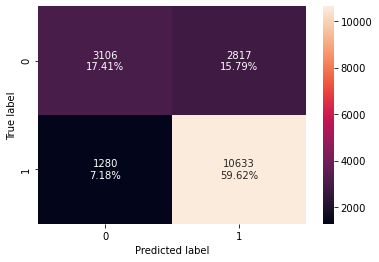

In [ ]:
confusion_matrix_sklearn(stacking_classifier, X_train, y_train)

In [ ]:
stacking_classifier_model_train_perf = model_performance_classification_sklearn(
    stacking_classifier, X_train, y_train
)
stacking_classifier_model_train_perf

,Accuracy,Recall,Precision,F1
0,0.770296,0.892554,0.790558,0.838465


#### Checking model performance on test set

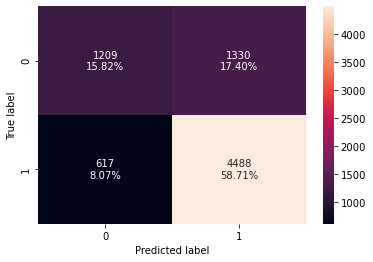

In [ ]:
confusion_matrix_sklearn(stacking_classifier, X_test, y_test)

In [ ]:
stacking_classifier_model_test_perf = model_performance_classification_sklearn(
    stacking_classifier, X_test, y_test
)
stacking_classifier_model_test_perf

,Accuracy,Recall,Precision,F1
0,0.74529,0.879138,0.771399,0.821752


* Stacking model has also given a good and generalized performance.
* The performance is comparable to the XGBoost model.
* We have received F1 scores of 0.83 and 0.81 on the training and test set, respectively.

## Model Comparison and Final Model Selection

**Comparing all models**

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        dtree_estimator_model_train_perf.T,
        dtree_estimator_model_train_perf.T,
        bagging_classifier_model_train_perf.T,
        bagging_estimator_tuned_model_train_perf.T,
        rf_estimator_model_train_perf.T,
        rf_tuned_model_train_perf.T,
        ab_classifier_model_train_perf.T,
        abc_tuned_model_train_perf.T,
        gb_classifier_model_train_perf.T,
        gbc_tuned_model_train_perf.T,
        xgb_classifier_model_train_perf.T,
        xgb_tuned_model_train_perf.T,
        stacking_classifier_model_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree",
    "Tuned Decision Tree",
    "Bagging Classifier",
    "Tuned Bagging Classifier",
    "Random Forest",
    "Tuned Random Forest",
    "Adaboost Classifier",
    "Tuned Adaboost Classifier",
    "Gradient Boost Classifier",
    "Tuned Gradient Boost Classifier",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "Stacking Classifier",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Decision Tree,Tuned Decision Tree,Bagging Classifier,Tuned Bagging Classifier,Random Forest,Tuned Random Forest,Adaboost Classifier,Tuned Adaboost Classifier,Gradient Boost Classifier,Tuned Gradient Boost Classifier,XGBoost Classifier,XGBoost Classifier Tuned,Stacking Classifier
Accuracy,0.712548,0.712548,0.985198,0.996187,1.0,0.769119,0.738226,0.719163,0.758802,0.764017,0.838753,0.765474,0.770296
Recall,0.931923,0.931923,0.985982,0.999916,1.0,0.918660,0.887182,0.781415,0.883740,0.882649,0.931419,0.881642,0.892554
Precision,0.720067,0.720067,0.991810,0.994407,1.0,0.776556,0.760688,0.794690,0.783042,0.789059,0.843482,0.791127,0.790558
F1,0.812411,0.812411,0.988887,0.997154,1.0,0.841652,0.819080,0.787997,0.830349,0.833234,0.885272,0.833935,0.838465


In [ ]:
# testing performance comparison

models_test_comp_df = pd.concat(
    [
        dtree_estimator_model_test_perf.T,
        dtree_estimator_model_test_perf.T,
        bagging_classifier_model_test_perf.T,
        bagging_estimator_tuned_model_test_perf.T,
        rf_estimator_model_test_perf.T,
        rf_tuned_model_test_perf.T,
        ab_classifier_model_test_perf.T,
        abc_tuned_model_test_perf.T,
        gb_classifier_model_test_perf.T,
        gbc_tuned_model_test_perf.T,
        xgb_classifier_model_test_perf.T,
        xgb_tuned_model_test_perf.T,
        stacking_classifier_model_test_perf.T,
    ],
    axis=1,
)
models_test_comp_df.columns = [
    "Decision Tree",
    "Tuned Decision Tree",
    "Bagging Classifier",
    "Tuned Bagging Classifier",
    "Random Forest",
    "Tuned Random Forest",
    "Adaboost Classifier",
    "Tuned Adaboost Classifier",
    "Gradient Boost Classifier",
    "Tuned Gradient Boost Classifier",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "Stacking Classifier",
]
print("Testing performance comparison:")
models_test_comp_df

Testing performance comparison:


,Decision Tree,Tuned Decision Tree,Bagging Classifier,Tuned Bagging Classifier,Random Forest,Tuned Random Forest,Adaboost Classifier,Tuned Adaboost Classifier,Gradient Boost Classifier,Tuned Gradient Boost Classifier,XGBoost Classifier,XGBoost Classifier Tuned,Stacking Classifier
Accuracy,0.706567,0.706567,0.691523,0.724228,0.727368,0.738095,0.734301,0.716641,0.744767,0.743459,0.733255,0.745160,0.745290
Recall,0.930852,0.930852,0.764153,0.895397,0.847209,0.898923,0.885015,0.781587,0.876004,0.871303,0.860725,0.869540,0.879138
Precision,0.715447,0.715447,0.771711,0.743857,0.768343,0.755391,0.757799,0.791510,0.772366,0.773296,0.767913,0.775913,0.771399
F1,0.809058,0.809058,0.767913,0.812622,0.805851,0.820930,0.816481,0.786517,0.820927,0.819379,0.811675,0.820063,0.821752


*  Tuned Random Forest model has given a good and generalized performance. We will use it as our final model.
* With the tuned random forest model we are getting the F1 score of 0.84 and 0.82 on the training and the test set, respectively.
* Let's check the important features of the final model.

### Important features of the final model

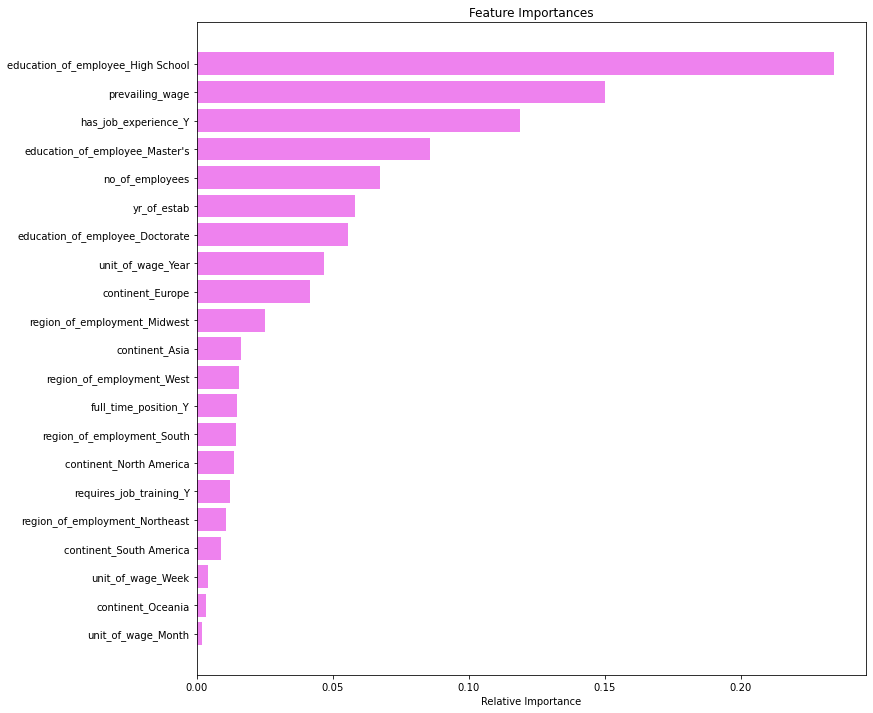

In [ ]:
feature_names = X_train.columns
importances = rf_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

* Looking at the feature importance of the Random Forest model, the top three important features to look for while certifying a visa are -Education of the employee, Job experience, and Prevailing Wage.

## Actionable Insights and Recommendations

**The profile of the applicants for whom the visa status can be approved:**

**Primary information to look at:**
- `Education level` - At least has a Bachelor's degree - Master's and doctorate are preferred.
- `Job Experience` - Should have some job experience. 
- `Prevailing wage` - The median prevailing wage of the employees for whom the visa got certified is around 72k. 


**Secondary information to look at:**

- `Unit of Wage`    - Applicants having a yearly unit of wage. 
- `Continent`       - Ideally the nationality and ethnicity of an applicant shouldn't matter to work in a country but previously it has been observed that applicants from Europe, Africa, and Asia have higher chances of visa certification.
- `Region of employment` - Our analysis suggests that the applications to work in the Mid-West region have more chances of visa approval. The approvals can also be made based on requirement of talent, from our analysis we see that:
    * The requirement for the applicants who have passed high school is most in the South region, followed by Northeast region.
    * The requirement for Bachelor's is mostly in South region, followed by West region.
    * The requirement for Master's is most in Northeast region, followed by South region.
    * The requirement for Doctorate's is mostly in West region, followed by Northeast region.
    
    
**The profile of the applicants for whom the visa status can be denied:**

**Primary information to look at:**
- `Education level` - Doesn't have any degree and has completed high school.
- `Job Experience` - Doesn't have any job experience. 
- `Prevailing wage` - The median prevailing wage of the employees for whom the visa got certified is around 65k. 


**Secondary information to look at:**

- `Unit of Wage`    - Applicants having an hourly unit of wage. 
- `Continent`       - Ideally the nationality and ethnicity of an applicant shouldn't matter to work in a country but previously it has been observed that applicants from South America, North America, and Oceania have higher chances of visa applications getting denied.

-----------

* Additional information of employers and employees can be collected to gain better insights. Information such as:
   * Employers: Information about  the wage they are offering to the applicant, Sector in which company operates in, etc
   * Employee's: Specialization in their educational degree, Number of years of experience, etc

___